In [281]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt

In [282]:
nqubits = 4         # Num qubits, min 4, always 2**num_layers qubits
num_iters = 150      # Number of training iterations
optimizer = "Adam"  # "Adam", "Nesterov"
loss_type = "cross-entropy" # "projectors", "cross-entropy"
with_bias = True    # Add a bias to the output of the quantum circuit
balanced_classes = False     # True: Same number of datapoints for each class. False: We cover homologously the j1,j2 space 
random = True

# Data hyper-parameters
num_data = 100      # How many ground states do we want?
num_train = 75      # Ground states that will be used for training
batch_size = 20     # batch training size

# Tweak hyper-parameters
max_weight_init = 0.01  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.02         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
nweights = 30*(layers-1) + 15
rng = np.random

In [283]:
def X(i):
    return qml.PauliX(i)

def Z(i):
    return qml.PauliZ(i)

# Gound states

In [284]:
def ground_state(j1, j2):
    
    hamiltonian = 0
    for i in range(nqubits):
        hamiltonian += Z(i)
        hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
        hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
    
    _, eigvecs = np.linalg.eigh(qml.matrix(hamiltonian))
    
    return eigvecs[:,0]

In [285]:
# Definir las coordenadas de los puntos de cada región
region01_coords = np.array([(-2, 1), (2, 1), (4, 3), (4, 4), (-4, 4), (-4, 3)])    # Class 0
region02_coords = np.array([(-3, -4), (0, -1), (3, -4)])                           # Class 0
region1_coords = np.array([(0, -1), (3, -4), (4, -4), (4, 3)])                     # Class 1
region2_coords = np.array([(0, -1), (-3, -4), (-4, -4), (-4, 3)])                  # Class 2
region3_coords = np.array([(-2, 1), (2, 1), (0, -1)])                              # Class 3

def labeling(x, y):

    # Crear objetos Polygon para cada región
    region01_poly = Polygon(region01_coords)
    region02_poly = Polygon(region02_coords)
    region1_poly = Polygon(region1_coords)
    region2_poly = Polygon(region2_coords)
    region3_poly = Polygon(region3_coords)
    
    
    punto = Point(x, y)
    if region01_poly.contains(punto):
        return 0
    elif region02_poly.contains(punto):
        return 0
    elif region1_poly.contains(punto):
        return 1
    elif region2_poly.contains(punto):
        return 2
    elif region3_poly.contains(punto):
        return 3
    else:
        return None # Si el punto no está en ninguna región

In [286]:
if not random:
    rng = np.random.RandomState(0)

if balanced_classes:
    
    npoints_class = num_data//4
    num_data = 4*npoints_class
    j_list = []
    num_0, num_1, num_2, num_3 = 0, 0, 0, 0

    while num_0 != npoints_class or num_1 != npoints_class or num_2 != npoints_class or num_3 != npoints_class:
        j = rng.uniform(-4, 4, 2)
        l = labeling(j[0], j[1])

        if l==0 and num_0 < npoints_class:
            num_0 += 1
            j_list.append(j)
        elif l==1 and num_1 < npoints_class:
            num_1 += 1
            j_list.append(j)
        elif l==2 and num_2 < npoints_class:
            num_2 += 1
            j_list.append(j)
        elif l==3 and num_3 < npoints_class:
            num_3 += 1
            j_list.append(j)

    j_list = np.array(j_list)
    
else:
    j_list = rng.uniform(-4, 4, (num_data,2))


gs_list = []
labels_list = []
for i in range(num_data):
    gs_list.append(ground_state(j_list[i,0], j_list[i,1]))
    labels_list.append(labeling(j_list[i,0], j_list[i,1]))

gs_list = np.array(gs_list)
labels_list = np.array(labels_list)

In [287]:
print(gs_list.shape)

(100, 16)


# CNN

In [288]:
def convolutional_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

def pooling_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

In [289]:
def cnn_circuit(weights, state_ini):

    qubits = list(range(nqubits))
    
    qml.QubitStateVector(state_ini, wires=qubits)

    for j in range(layers-1):
        
        len_qubits = len(qubits)
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*2*j:15*(2*j+1)])
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i+1], qubits[(2*i+2)%len_qubits], weights[15*2*j:15*(2*j+1)])
            
        for i in range(len_qubits//2):
            pooling_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*(2*j+1):15*(2*j+2)])

        qub = []
        for i in range(len_qubits):
            if i%2 == 1:
                qub.append(qubits[i])
                
        qubits = qub
    
    convolutional_layer(qubits[0], qubits[1], weights[15*(2*layers-2):15*(2*layers-1)])
    
    return qml.expval(Z(qubits[0])), qml.expval(Z(qubits[1])), qml.expval(Z(qubits[0]) @ Z(qubits[1]))

# dev_draw = qml.device("qiskit.aer", wires=nqubits)
dev = qml.device("default.qubit", wires=nqubits)

# cnn_draw = qml.QNode(cnn_circuit, dev_draw)
cnn_circuit = qml.QNode(cnn_circuit, dev, interface="autograd")


def cnn(weights, state_ini):
    z0, z1, zz01 = cnn_circuit(weights, state_ini)

    proj_00 = (1+zz01+z0+z1)/4
    proj_01 = (1-zz01-z0+z1)/4
    proj_10 = (1-zz01+z0-z1)/4
    proj_11 = (1+zz01-z0-z1)/4

    return pnp.array([proj_00, proj_01, proj_10, proj_11])

In [290]:
def variational_classifier(weights, bias, state_ini):
    return cnn(weights, state_ini) + bias

In [291]:
weights = np.random.uniform(0, 2*np.pi, nweights)
drawer = qml.draw(cnn_circuit)
print(drawer(weights, gs_list[0]))

# z0, z1, zz01 = cnn_draw(gs_list[0], weights)
# print(z0, z1, zz01)
# dev_draw._circuit.draw(output="mpl")

0: ─╭|Ψ⟩──U3(0.60,3.79,2.88)──U3(1.99,3.40,2.82)─╭X──RZ(5.96)─╭●───────────╭X──U3(5.38,6.07,5.34)
1: ─├|Ψ⟩─────────────────────────────────────────╰●──RY(1.16)─╰X──RY(6.04)─╰●──U3(0.60,3.79,2.88)
2: ─├|Ψ⟩──U3(0.60,3.79,2.88)──U3(1.99,3.40,2.82)─╭X──RZ(5.96)─╭●───────────╭X──U3(5.38,6.07,5.34)
3: ─╰|Ψ⟩─────────────────────────────────────────╰●──RY(1.16)─╰X──RY(6.04)─╰●──U3(0.60,3.79,2.88)

───U3(5.30,6.15,1.45)──────────────────────────────────────────────────────────────────────╭●
───U3(1.99,3.40,2.82)─╭X──RZ(5.96)─╭●───────────╭X──U3(5.38,6.07,5.34)──U3(5.30,6.15,1.45)─│─
───U3(5.30,6.15,1.45)─╰●──RY(1.16)─╰X──RY(6.04)─╰●─────────────────────────────────────────│─
───U3(1.99,3.40,2.82)──────────────────────────────────────────────────────────────────────╰X

───RY(1.16)─╭X──RY(6.04)─╭●──U3(4.92,3.90,4.73)──U3(4.99,4.50,2.83)─╭X──RZ(4.34)─╭●───────────╭X
────────────│────────────│──────────────────────────────────────────╰●──RY(2.60)─╰X──RY(5.46)─╰●
────────────│────────────│───U3(4.92

# Loss and accuracy

In [292]:
def log2_arraybox(abox):
    return pnp._np.numpy_boxes.ArrayBox(value = np.log2(abox._value), trace = abox._trace, node = abox._node)

def exp_arraybox(abox):
    return pnp._np.numpy_boxes.ArrayBox(value = np.exp(abox._value), trace = abox._trace, node = abox._node)

def loss(weights, bias, ground_states, labels):
    cost = 0
    
    for j in range(len(labels)):

        proj = variational_classifier(weights, bias, ground_states[j])
        

        if loss_type == "projectors":
                cost += proj[labels[j]]
                
            # adding extra terms to equalize incorrect classes might help in the optimization, 
            # although it is not required
            
            # if labels[j] == 0:
            #     cost += proj_00 + ((proj_01-proj_10)**2 + (proj_01-proj_11)**2 + (proj_10-proj_11)**2)/3
            # elif labels[j] == 1:
            #     cost += proj_01 + ((proj_00-proj_10)**2 + (proj_00-proj_11)**2 + (proj_10-proj_11)**2)/3
            # elif labels[j] == 2:
            #     cost += proj_10 + ((proj_00-proj_01)**2 + (proj_00-proj_11)**2 + (proj_01-proj_11)**2)/3
            # elsif labels[j] == 3:
            #     cost += proj_11 + ((proj_00-proj_01)**2 + (proj_00-proj_10)**2 + (proj_01-proj_10)**2)/3
            # else:
            #     raise Exception("Incorrect label")

        elif loss_type == "cross-entropy":
                
                if isinstance(proj[labels[j]], pnp._np.numpy_boxes.ArrayBox):
                    cost -= log2_arraybox(proj[labels[j]])

                else:
                    cost -= np.log2(proj[labels[j]])
    
    return cost/len(labels)

In [293]:
def pred_acc(weights, bias, ground_states, labels):
    accuracy_data = 0
    predictions = []

    for j in range(len(labels)):
        projectors = variational_classifier(weights, bias, ground_states[j])
        
        if loss_type == "projectors":
            pred = np.argmin(projectors)
        elif loss_type == "cross-entropy":
            pred = np.argmax(projectors)

        accuracy_data += 1 if pred == labels[j] else 0
        predictions.append(pred)
            
    return predictions, accuracy_data*100/len(labels)

# Training

In [294]:
if not random:
    rng = np.random.RandomState(0)

# Splitting the data into training and validation
index = rng.permutation(range(num_data))

gs_train = gs_list[index[:num_train]]
labels_train = labels_list[index[:num_train]]
gs_val = gs_list[index[num_train:]]
labels_val = labels_list[index[num_train:]]

# We need these later for plotting
j_train = j_list[index[:num_train]]
j_val = j_list[index[num_train:]]

# weights and bias initialization
weights_init = pnp.random.uniform(0, max_weight_init, nweights, requires_grad=True)

if with_bias:
    bias_init = pnp.array([0.0]*4, requires_grad=True)
else:
    bias_init = np.array([0.0]*4)

# train the variational classifier
if optimizer == "Nesterov":
    opt = NesterovMomentumOptimizer(stepsize)
elif optimizer == "Adam":
    opt = qml.AdamOptimizer(stepsize)
    
    
weights = []
bias = []
losses = []
pred_train_arr = []
pred_val_arr = []
acc_train_arr = []
acc_val_arr = []

w = weights_init
b = bias_init

for it in range(num_iters):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    gs_train_batch = gs_train[batch_index]
    labels_train_batch = labels_train[batch_index]
    
    w, b, _, _ = opt.step(loss, w, b, gs_train_batch, labels_train_batch)
    weights.append(w)
    bias.append(b)
    
    # Compute predictions and accuracy on train and validation set
    pred_train, acc_train = pred_acc(w, b, gs_train, labels_train)
    pred_val, acc_val = pred_acc(w, b, gs_val, labels_val) if len(labels_val)>0 else [0, 0]

    # Save prediction for later plotting
    pred_train_arr.append(pred_train)
    pred_val_arr.append(pred_val)
    acc_train_arr.append(acc_train)
    acc_val_arr.append(acc_val)

    l = loss(w, b, gs_list, labels_list)
    losses.append(l)

    print(
        "Iter: {:5d} | Loss: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f}"
        "".format(it+1, l, acc_train, acc_val)
    )

d:\Github\venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Iter:     1 | Loss: 1.8844976 | Acc train: 12.0000000 | Acc validation: 12.0000000
Iter:     2 | Loss: 1.7742498 | Acc train: 13.3333333 | Acc validation: 12.0000000
Iter:     3 | Loss: 1.6697209 | Acc train: 14.6666667 | Acc validation: 12.0000000
Iter:     4 | Loss: 1.5756780 | Acc train: 16.0000000 | Acc validation: 12.0000000
Iter:     5 | Loss: 1.4849044 | Acc train: 16.0000000 | Acc validation: 16.0000000
Iter:     6 | Loss: 1.4014950 | Acc train: 16.0000000 | Acc validation: 16.0000000
Iter:     7 | Loss: 1.3243171 | Acc train: 17.3333333 | Acc validation: 16.0000000
Iter:     8 | Loss: 1.2549480 | Acc train: 16.0000000 | Acc validation: 16.0000000
Iter:     9 | Loss: 1.1889174 | Acc train: 16.0000000 | Acc validation: 16.0000000
Iter:    10 | Loss: 1.1243932 | Acc train: 17.3333333 | Acc validation: 20.0000000
Iter:    11 | Loss: 1.0619174 | Acc train: 17.3333333 | Acc validation: 16.0000000
Iter:    12 | Loss: 1.0011244 | Acc train: 18.6666667 | Acc validation: 16.0000000
Iter

In [ ]:
plus_iter = 0

for i in range(plus_iter):
    
    it+=1

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    gs_train_batch = gs_train[batch_index]
    labels_train_batch = labels_train[batch_index]
    
    w, b, _, _ = opt.step(loss, w, b, gs_train_batch, labels_train_batch)
    weights.append(w)
    bias.append(b)
    
    # Compute predictions and accuracy on train and validation set
    pred_train, acc_train = pred_acc(w, b, gs_train, labels_train)
    pred_val, acc_val = pred_acc(w, b, gs_val, labels_val) if len(labels_val)>0 else [0, 0]

    # Save prediction for later plotting
    pred_train_arr.append(pred_train)
    pred_val_arr.append(pred_val)
    acc_train_arr.append(acc_train)
    acc_val_arr.append(acc_val)

    l = loss(w, b, gs_list, labels_list)
    losses.append(l)

    print(
        "Iter: {:5d} | Loss: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f}"
        "".format(it+1, l, acc_train, acc_val)
    )

# Plotting

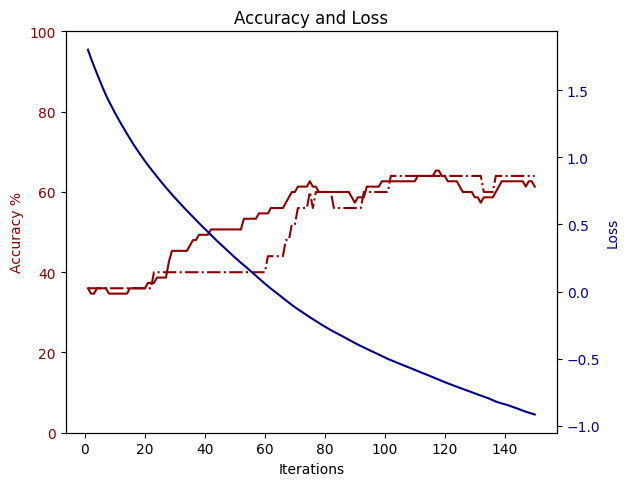

In [ ]:
iterations = range(1, len(acc_train_arr)+1)

fig, ax1 = plt.subplots()

color1 = 'darkred'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Accuracy %', color=color1)
ax1.plot(iterations, acc_train_arr, label="Training", color=color1)
ax1.plot(iterations, acc_val_arr, '-.', label="Validation", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0,100)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'darkblue'
ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with ax1
ax2.plot(iterations, losses, label="Loss", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.title("Accuracy and Loss")
plt.show()

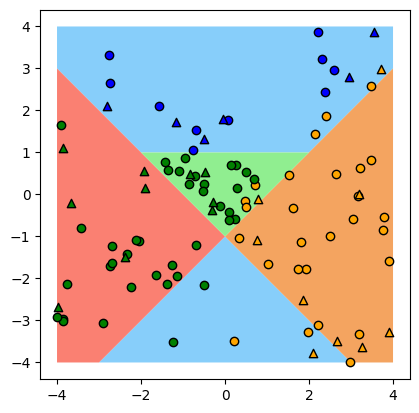

In [ ]:
plot_iter = it+1 #it+1

# define regions coordinates
x01, y01 = region01_coords[:,0], region01_coords[:,1]
x02, y02 = region02_coords[:,0], region02_coords[:,1]
x1, y1 = region1_coords[:,0], region1_coords[:,1]
x2, y2 = region2_coords[:,0], region2_coords[:,1]
x3, y3 = region3_coords[:,0], region3_coords[:,1]

# plt.figure(figsize=(8, 8))

# put the regions into the plot
plt.fill(x01, y01, facecolor='lightskyblue')    # class 0
plt.fill(x02, y02, facecolor='lightskyblue')    # class 0
plt.fill(x1, y1, facecolor='sandybrown')        # class 1
plt.fill(x2, y2, facecolor='salmon')            # class 2
plt.fill(x3, y3, facecolor='lightgreen')        # class 3

pred_train_plot = np.array(pred_train_arr[plot_iter-1])
pred_val_plot = np.array(pred_val_arr[plot_iter-1])

colors = ["b", "orange", "r", "g"]

# plot datapoints
for i in range(4):
    plt.scatter(
        j_train[:, 0][pred_train_plot==i],
        j_train[:, 1][pred_train_plot==i],
        c=colors[i],
        marker="o",
        edgecolors="k",
        label=f"class {i+1} train",
    )
    plt.scatter(
        j_val[:, 0][pred_val_plot==i],
        j_val[:, 1][pred_val_plot==i],
        c=colors[i],
        marker="^",
        edgecolors="k",
        label=f"class {i+1} validation",
    )


# plt.legend()
plt.axis('square')
plt.show()


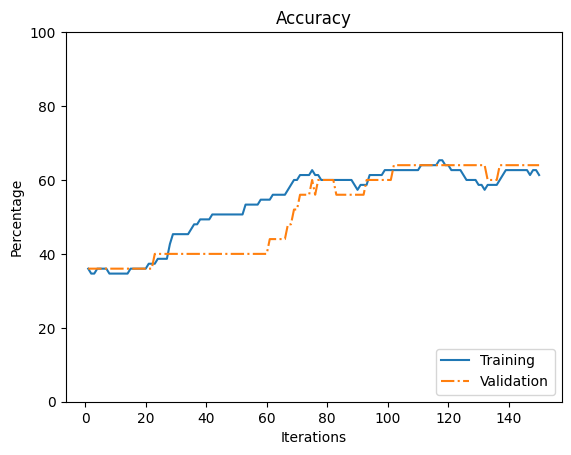

In [ ]:
# from importlib import reload
# plt=reload(plt)

plt.plot(range(1, len(acc_train_arr)+1), acc_train_arr, label="Training")
plt.plot(range(1, len(acc_train_arr)+1), acc_val_arr, '-.', label="Validation")

plt.xlabel("Iterations")
plt.ylabel("Percentage")

plt.ylim(0, 100)
plt.title("Accuracy")

plt.legend(loc="lower right")
plt.show()

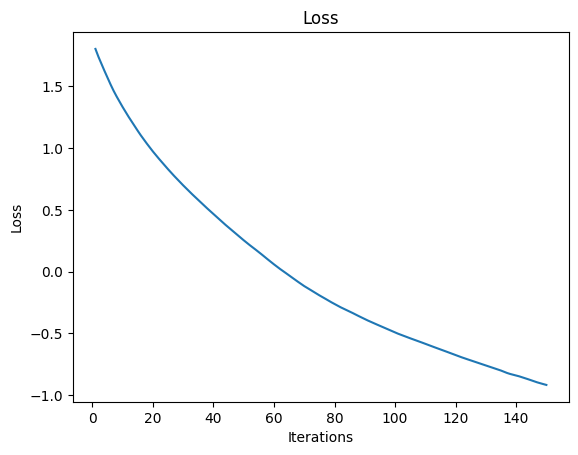

In [ ]:
plt.plot(range(1, len(acc_train_arr)+1), losses)

plt.xlabel('Iterations')
plt.ylabel("Loss")
plt.title("Loss")

plt.show()